# Denpasar Weather Forecasting with TensorFlow

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import io

mpl.rcParams['figure.figsize'] = (12, 5)
mpl.rcParams['axes.grid'] = False

## The weather dataset

This dataset is collected from https://openweathermaps.org pointed in Denpasar, Bali. The dataset contains hourly weather data from January 1st 1990 until January 7th 2020. Originally there are 32 features, although has been reduced the unnecessary features to  11 features as shown below. You can access this data at https://www.kaggle.com/cornflake15/denpasarbalihistoricalweatherdata

In [3]:
usecols = ['dt_iso', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 
           'clouds_all', 'weather_main', 'weather_description']
df = pd.read_csv('openweatherdata-denpasar-1990-2020v0.1.csv', parse_dates=True, index_col='dt_iso', usecols=usecols)
df.head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,weather_description
dt_iso,,,,,,,,,,
1990-01-01 00:00:00,25.82,25.82,25.82,1010.0,86,1.36,225,98,Rain,light rain
1990-01-01 01:00:00,26.20,26.20,26.20,1011.0,84,2.09,247,91,Rain,light rain
1990-01-01 02:00:00,26.45,26.45,26.45,1011.0,84,2.44,262,94,Rain,light rain
1990-01-01 03:00:00,26.80,26.80,26.80,1011.0,82,2.29,271,94,Rain,light rain
1990-01-01 04:00:00,27.04,27.04,27.04,1010.0,82,1.71,274,76,Clouds,broken clouds


In [4]:
df.shape

(264924, 10)

**Data Split Function**

In [5]:
# Split the data by percentage
def num_data_train(percentage, data_length):
    num_data = percentage / 100 * data_length
    return int(num_data)

From this section, the code is adapted from **Time Series Tensorflow Tutorial**.

Source: https://www.tensorflow.org/tutorials/structured_data/time_series

## Forecast a univariate time series

In this part, we tested how ML method works at time series data. We conducted simple forecasting on single feature (temperature).

**Split the data**

In [6]:
TRAIN_SPLIT = num_data_train(70, df.shape[0]) # Split 70% of the data for training
tf.random.set_seed(13) # Setting seed to ensure reproducibility
print('Length of Data Train: {}'.format(TRAIN_SPLIT))

Length of Data Train: 185446


In [8]:
# Train a model using a single feature (temperature)
dt_temp = df['temp']
dt_temp.tail()

dt_iso
2020-01-07 19:00:00    27.0
2020-01-07 20:00:00    27.0
2020-01-07 21:00:00    28.0
2020-01-07 22:00:00    28.0
2020-01-07 23:00:00    28.0
Name: temp, dtype: float64

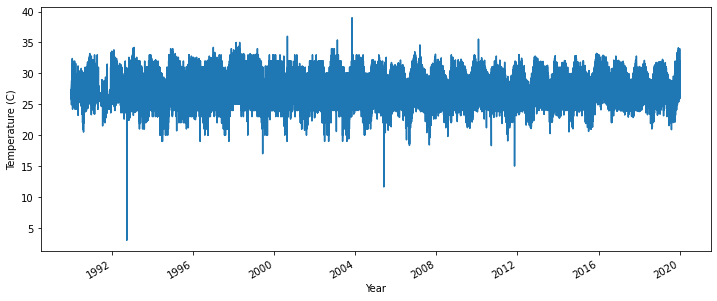

In [10]:
dt_temp.plot(subplots=True)
plt.xlabel('Year')
plt.ylabel('Temperature (C)')
plt.show()

In [13]:
# Convert the dataframe into numpy array
array_temp = dt_temp.values
print(array_temp[:10]) # Print 10 elements for checking

[25.82 26.2  26.45 26.8  27.04 27.23 27.32 27.29 27.34 27.23]


In [16]:
# Scaling the features
array_temp_mean = array_temp[:TRAIN_SPLIT].mean()
array_temp_std = array_temp[:TRAIN_SPLIT].std()
print('Training Data Mean: {}'.format(array_temp_mean))
print('\nTraining Data Std.Dev: {}'.format(array_temp_std))

Training Data Mean: 27.1836268239811

Training Data Std.Dev: 1.9980058874922433


In [17]:
# Standardize the data
array_temp = (array_temp - array_temp_mean) / array_temp_std
print(array_temp)

[-0.6824939  -0.49230427 -0.36717951 ...  0.40859398  0.40859398
  0.40859398]


In [20]:
# create a function that return the time windows for the model to train on
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In this part, the model will be given the last **`n`** recorded temperature observation, and needs to learn to predict the temperature at the next **`m`** time step.

In [21]:
# Create the univariate model
data_past_history = 30 # number of last recorded data (n)
data_future_target = 0 # number of time step (m)

x_train, y_train = univariate_data(array_temp, 0, TRAIN_SPLIT, data_past_history, data_future_target)
x_val, y_val = univariate_data(array_temp, TRAIN_SPLIT, None, data_past_history, data_future_target)

print('Single window of past history:')
print(x_train[0])
print('\n Target temperature to predict:')
print(y_train[0])

Single window of past history:
[[-0.6824939 ]
 [-0.49230427]
 [-0.36717951]
 [-0.19200485]
 [-0.07188509]
 [ 0.02320973]
 [ 0.06825464]
 [ 0.05323967]
 [ 0.07826462]
 [ 0.02320973]
 [ 0.10829456]
 [ 0.07325963]
 [-0.19700984]
 [-0.44725935]
 [-0.56237413]
 [-0.63244399]
 [-0.63744898]
 [-0.65246396]
 [-0.69750887]
 [-0.8326436 ]
 [-1.01782824]
 [-1.0428532 ]
 [-1.03284321]
 [-1.07788813]
 [-1.01782824]
 [-0.99280329]
 [-0.96777834]
 [-0.8326436 ]
 [-0.85766856]
 [-0.75256376]]

 Target temperature to predict:
-0.8076186532194914


Now that the data has been created, The information given to the network is given in blue, and it must predict the value at the red cross.

In [22]:
def create_time_steps(length):
    return list(range(-length, 0))

In [23]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
       
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'c:\\users\\rudyh\\documents\\python_code\\lib\\site-packages\\matplotlib\\pyplot.py'>

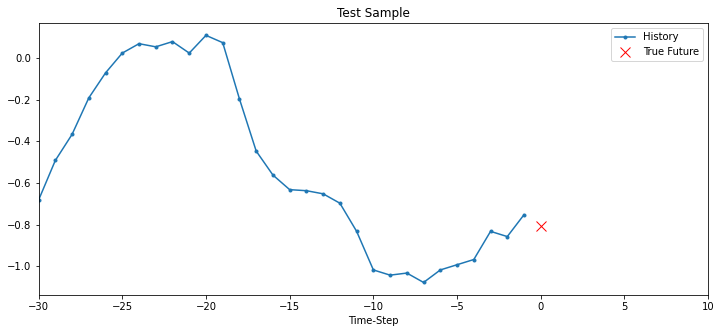

In [24]:
show_plot([x_train[0], y_train[0]], 0, 'Test Sample')

**We compared two models, first is simple `sequential` model with 2 layers and second is simple `LSTM` model with 1 layer.**

In [25]:
from tensorflow.keras import layers
tf.keras.backend.clear_session()  # For easy reset of notebook state.

# Normal Sequential model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_shape=x_train.shape[-2:]), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compare with simple LSTM Model, according to several sources LSTM is suitable for modeling time series data
model_2 = tf.keras.models.Sequential(
    [tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]), tf.keras.layers.Dense(1)]
)
model_1.summary()
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 16)            32        
_________________________________________________________________
dense_1 (Dense)              (None, 30, 16)            272       
_________________________________________________________________
dense_2 (Dense)              (None, 30, 1)             17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 

In [26]:
model_1.compile(optimizer='adam', loss='mae')
model_2.compile(optimizer='adam', loss='mae')

**Further reading:**
    
    1. https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
    2. https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list/45944225
    3. https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [28]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

datatrain = tf.data.Dataset.from_tensor_slices((x_train, y_train))
datatrain = datatrain.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

dataval = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataval = dataval.batch(BATCH_SIZE).repeat()

In [29]:
EPOCHS = 10
STEPS_PER_EPOCH = 200 # number of time steps
VALIDATION_STEPS = 50

# Train the model
model_1_history = model_1.fit(datatrain, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=dataval, 
                      validation_steps=VALIDATION_STEPS)
model_2_history = model_2.fit(datatrain, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=dataval, 
                      validation_steps=VALIDATION_STEPS)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6015 - val_loss: 0.7122
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.8093 - val_loss: 0.7014
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.7982 - val_loss: 0.7006
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6210 - val_loss: 0.7489
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.7528 - val_loss: 0.7064
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.8003 - val_loss: 0.7030
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.7804 - val_loss: 0.7043
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5841 - val_loss: 0.7250
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.8101 - val_loss: 0.7049
Epoch 10/10
200/200 [==============================] - 1s

In [30]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

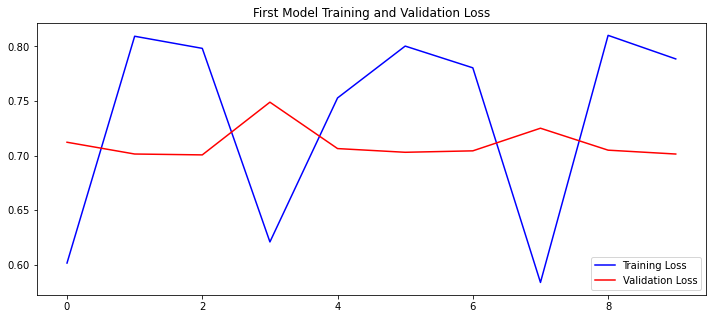

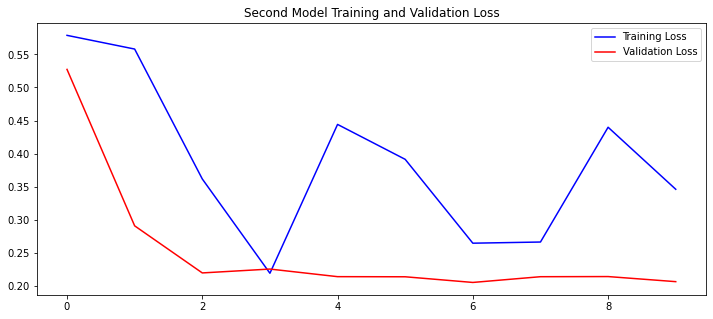

In [31]:
plot_train_history(model_1_history, 'First Model Training and Validation Loss')
plot_train_history(model_2_history, 'Second Model Training and Validation Loss')

**The graph above indicates that the model performance was not really good because we only use single feature (temperature)**
First model is not really clear whether it is overfit or underfit, but the second model clealy underfit. Second model need hyperparameter tuning or because it used only single feature.

In the next section we will use multi-feature/multivariate forecasting.

Further readings:
    1. https://developers.google.com/machine-learning/crash-course/descending-into-ml/training-and-loss
    2. https://stackoverflow.com/questions/48226086/training-loss-and-validation-loss-in-deep-learning

# Multivariate Forecasting

In this part we decided to use multivariate forecasting to see how the LSTM method performs. We use five features that has the most important parts in forecasting weather, i.e, **average air temperature** (`temp`), **minimum air temperature** (`temp_min`), **maximum air temperature** (`temp_max`), **air pressure** (`pressure`), and **air humidity** (`humidity`).

In [32]:
# df_multivariate = df.drop(['weather_main', 'weather_description'], axis=1)
df_multivariate = df[['temp', 'temp_min', 'temp_max', 'pressure', 'humidity']]
df_multivariate.head()

,temp,temp_min,temp_max,pressure,humidity
dt_iso,,,,,
1990-01-01 00:00:00,25.82,25.82,25.82,1010.0,86
1990-01-01 01:00:00,26.20,26.20,26.20,1011.0,84
1990-01-01 02:00:00,26.45,26.45,26.45,1011.0,84
1990-01-01 03:00:00,26.80,26.80,26.80,1011.0,82
1990-01-01 04:00:00,27.04,27.04,27.04,1010.0,82


Analyze the features correlation with correlation matrix

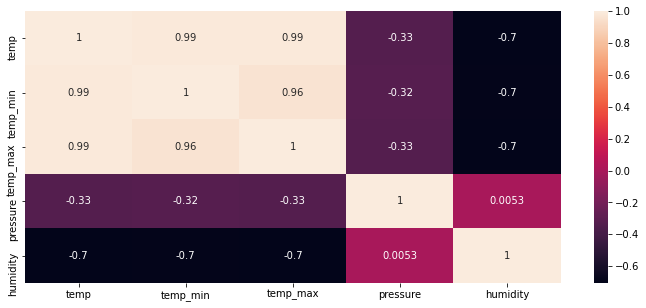

In [33]:
import seaborn as sns

sns.heatmap(df_multivariate.corr(), annot=True)
plt.show()

We didn't used 2020 data because there was contain only seven days of data therefore we used data from January 1st 1990 until December 31st 2019.

In [35]:
# Don't use data in 2020
df_multivariate = df_multivariate.loc['1990':'2019']
df_multivariate.tail()

,temp,temp_min,temp_max,pressure,humidity
dt_iso,,,,,
2019-12-31 19:00:00,27.08,27.0,27.2,1009.0,88
2019-12-31 20:00:00,26.64,26.0,27.0,1009.0,94
2019-12-31 21:00:00,26.00,26.0,26.0,1009.0,94
2019-12-31 22:00:00,26.00,26.0,26.0,1009.0,94
2019-12-31 23:00:00,27.00,27.0,27.0,1010.0,88


In [36]:
# Convert the dataframe to numpy array
# df_multivariate = df_multivariate.drop('date', axis=1)
dt_multivariate = df_multivariate.values
print('Number of dataset: {}'.format(len(df_multivariate)))
print('10 samples of data: \n{}'.format(dt_multivariate[:10]))

Number of dataset: 264756
10 samples of data: 
[[  25.82   25.82   25.82 1010.     86.  ]
 [  26.2    26.2    26.2  1011.     84.  ]
 [  26.45   26.45   26.45 1011.     84.  ]
 [  26.8    26.8    26.8  1011.     82.  ]
 [  27.04   27.04   27.04 1010.     82.  ]
 [  27.23   27.23   27.23 1009.     82.  ]
 [  27.32   27.32   27.32 1008.     82.  ]
 [  27.29   27.29   27.29 1008.     82.  ]
 [  27.34   27.34   27.34 1007.     81.  ]
 [  27.23   27.23   27.23 1007.     82.  ]]


In [37]:
#Normalizing the data using StandardScaler from sklearn, instead of using the conventional calculation like the above before
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dt_multivariate = sc.fit_transform(dt_multivariate)
print('Normalized data:')
print(dt_multivariate[10])
print(dt_multivariate.shape)

Normalized data:
[ 0.06489342  0.1281178   0.00158411 -0.88977112  0.01811545]
(264756, 5)
